In [46]:
import cv2
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import numpy.linalg as la

Clase para almacenar la información de las imágenes

In [2]:
 # '..\\parking_sequence\\s=camera_front_mirror_d1=4.501_d2=4.499_d3=2.585_d4=2.583_a1=27.795_a2=27.744_a3=125.972_a4=125.993_t=1729649590.26049.jpg',
class ImageInfo:
    def __init__(self, image_path):
        self.image_path = image_path
        self.distances, self.angles, self.time = self.get_tags(image_path)

    def get_tags(self, image_path):
        distances = []
        angles = []
        time = 0
        filename = os.path.basename(image_path)
        filename = filename.split('_')
        for word in filename:
            if word.startswith('d'):
                distances.append(float(word[3:]))
            if word.startswith('a'):
                angles.append(float(word[3:]))
            if word.startswith('t'):
                time = float(word[2:])

        return distances, angles, time

cargar las imágenes de un directorio

In [3]:
def load_tagged_images(directory):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            route = os.path.join(directory, filename)
            images.append(ImageInfo(route))
    return images

images_info = load_tagged_images('..\\parking_sequence')

In [39]:
images_info.sort(key=lambda x: x.time, reverse=False)
for image in images_info:
    print(image.distances, image.angles, image.time)

[13.655, 13.655, 8.26, 8.26] [8.631, 8.639, 14.398, 14.408] 1729650622.6494455
[13.656, 13.656, 8.261, 8.261] [8.645, 8.654, 14.421, 14.43] 1729650622.7136624
[13.657, 13.657, 8.263, 8.263] [8.68, 8.688, 14.477, 14.485] 1729650622.8016548
[13.658, 13.658, 8.264, 8.265] [8.703, 8.71, 14.513, 14.522] 1729650622.869142
[13.658, 13.659, 8.265, 8.265] [8.717, 8.724, 14.536, 14.544] 1729650622.9372764
[13.659, 13.659, 8.266, 8.266] [8.73, 8.736, 14.555, 14.563] 1729650623.0219197
[13.659, 13.659, 8.266, 8.267] [8.737, 8.744, 14.568, 14.575] 1729650623.1263733
[13.657, 13.657, 8.265, 8.265] [8.745, 8.751, 14.58, 14.587] 1729650623.2261791
[13.546, 13.546, 8.156, 8.156] [8.872, 8.866, 14.835, 14.83] 1729650623.3315523
[13.372, 13.372, 7.985, 7.986] [9.004, 9.0, 15.175, 15.173] 1729650623.4231892
[13.163, 13.163, 7.782, 7.782] [9.151, 9.146, 15.585, 15.582] 1729650623.5136142
[12.884, 12.885, 7.51, 7.51] [9.351, 9.347, 16.163, 16.163] 1729650623.618725
[12.583, 12.583, 7.217, 7.218] [9.579, 9.5

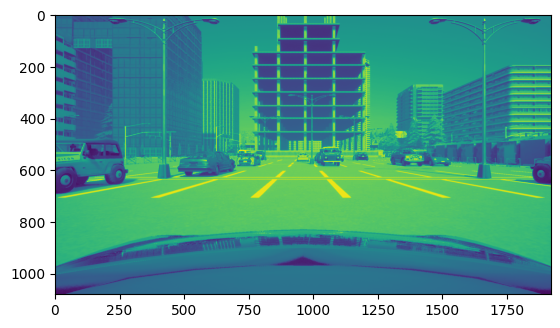

In [40]:
image = cv2.imread(images_info[0].image_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(image)
plt.show()

# Below the horizon

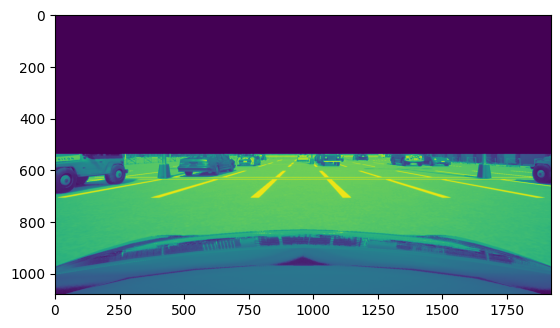

numpy.ndarray

In [41]:
height, width = image.shape
half_width = height//2
bottom_half=image.copy()
bottom_half[0:half_width,:] = 0
#bottom_half = image.crop((0, height // 2, width, height))
plt.imshow(bottom_half)
plt.show()
type (image)

# Thresholded image

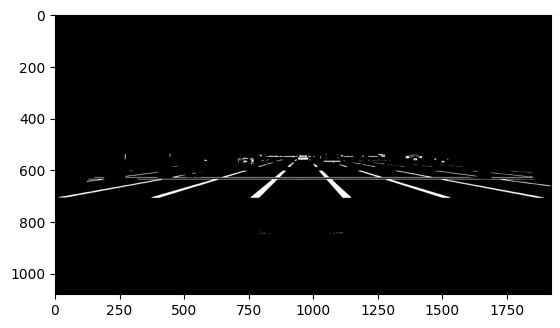

In [42]:
# Umbralizar la imagen
threshold = 210
_, binary_gray_image = cv2.threshold(bottom_half, threshold, 255, cv2.THRESH_BINARY)

# Mostrar la imagen binaria
plt.imshow(binary_gray_image, cmap='gray')
plt.show()

# Canny contours

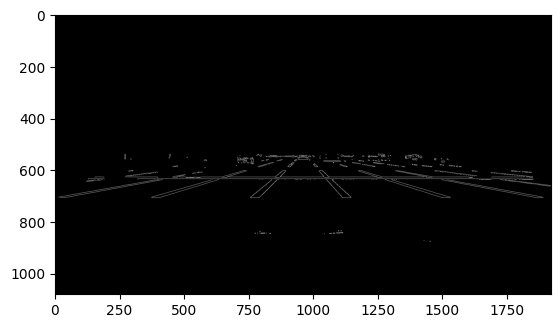

In [43]:
# Convertir la imagen PIL a un array NumPy
image_np = binary_gray_image

# Detector de bordes Canny
edges = cv2.Canny(image_np, 100, 200)

plt.imshow(edges, cmap="gray")
plt.show()

# Transformada de Hough

In [47]:
# rho: Resolución del parámetro de distancia en píxeles.
# theta: Resolución del parámetro de ángulo en radianes np.pi / 180 = 1 grado
# threshold: Número mínimo de intersecciones en el espacio de parámetros para considerar una línea.
# minLineLength: Longitud mínima de la línea que se detectará.
# maxLineGap: Distancia máxima entre segmentos de línea que aún se considerarán parte de la misma línea.
lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=50, minLineLength=50, maxLineGap=40)

copia de la imagen original para dibujar las líneas

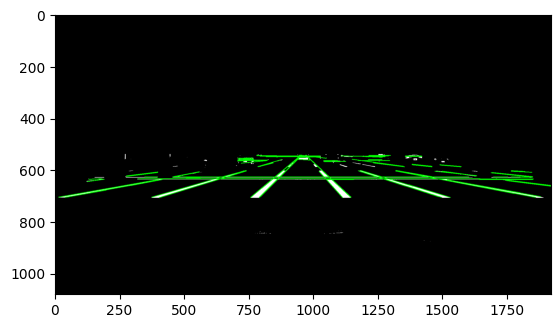

In [48]:
image_with_lines = np.copy(image_np)
if len(image_with_lines.shape) == 2:  # Si es una imagen en escala de grises
    image_with_lines = cv2.cvtColor(image_with_lines, cv2.COLOR_GRAY2BGR)  # Convertir a BGR para visualizar las líneas en color

# Dibujar las líneas detectadas en la imagen
lineEqs = np.zeros((len(lines), 3))
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(image_with_lines, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Dibujar la línea en verde con grosor de 2

# Mostrar la imagen con las líneas detectadas
plt.imshow(cv2.cvtColor(image_with_lines, cv2.COLOR_BGR2RGB))  # Convertir de BGR a RGB para matplotlib
plt.show()

solamente las lineas , sin la imagen

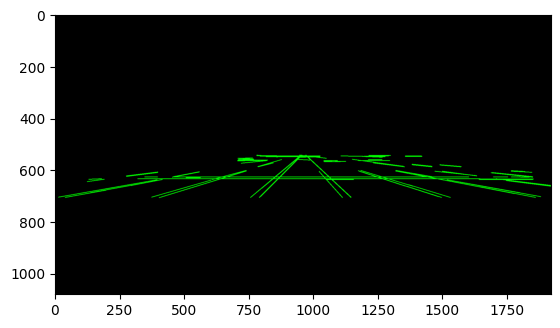

In [49]:
lines_only = np.zeros_like(image_with_lines)

# Dibujar las líneas detectadas en la imagen en negro
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(lines_only, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Dibujar la línea en verde con grosor de 2

# Mostrar la imagen con solo las líneas
plt.imshow(cv2.cvtColor(lines_only, cv2.COLOR_BGR2RGB))  # Convertir de BGR a RGB para matplotlib
plt.show()

# Calculamos el espacio nulo (a,b,c) de cada recta con SVD

ax+by+c=0 ecuacion de la recta

\begin{pmatrix}
x_1 & y_1 & 1 \\
x_2 & y_2 & 1
\end{pmatrix}
\begin{pmatrix}
a \\
b \\
c
\end{pmatrix}
=
\begin{pmatrix}
0 \\
0
\end{pmatrix}

In [52]:
def null_space(A, rcond=None):
    u, s, vh = la.svd(A, full_matrices=True)
    M, N = u.shape[0], vh.shape[1]
    if rcond is None:
        rcond = np.finfo(s.dtype).eps * max(M, N)
    tol = np.amax(s) * rcond
    num = np.sum(s > tol, dtype=int)
    Q = vh[num:,:].T.conj()
    return Q

In [53]:
if lines is not None:
    i=0
    for line in lines:
        x1, y1, x2, y2 = line[0]
        # Calculamos las equaciones de la lineas.
        M=np.array([[x1,y1,1],[x2,y2,1]])
        lineEqs[i,:] = null_space(M)[:,0]
        i+=1

In [54]:
print(lineEqs, lineEqs.shape)

[[-3.14180325e-19 -1.57480120e-03  9.99998760e-01]
 [ 1.71940037e-19 -1.59235467e-03  9.99998732e-01]
 [-2.48279389e-04 -1.41185742e-03  9.99998973e-01]
 [-3.58865692e-04 -1.22280162e-03  9.99999188e-01]
 [ 1.00502624e-19 -1.56739619e-03  9.99998772e-01]
 [ 5.47262117e-04 -2.84724210e-03  9.99995797e-01]
 [-3.67854224e-04 -1.20356188e-03  9.99999208e-01]
 [ 2.97441144e-04 -2.37952915e-03  9.99997125e-01]
 [ 3.35381847e-04 -2.47809920e-03  9.99996873e-01]
 [ 4.85704509e-04 -2.71474127e-03  9.99996197e-01]
 [ 2.83804829e-04 -2.33593206e-03  9.99997231e-01]
 [-3.52944662e-04 -1.22995867e-03  9.99999181e-01]
 [ 1.42570461e-03 -4.41968431e-03  9.99989217e-01]
 [ 1.98290515e-19 -1.81817881e-03  9.99998347e-01]
 [-6.68448899e-04 -6.68448899e-04  9.99999553e-01]
 [ 4.78476260e-04 -2.69860611e-03  9.99996244e-01]
 [-1.25361942e-18 -1.82815051e-03  9.99998329e-01]
 [ 2.65204382e-04 -2.29843798e-03  9.99997323e-01]
 [ 2.09447501e-19 -1.56739619e-03  9.99998772e-01]
 [ 2.34287439e-04 -2.28430253e-

# calculamos la intersecion de cada recta con las demas

In [55]:
def areEqual(a, b, ord):
#
# areEqual(a, b, ord)
#
# Regresa verdadero si la diferencia entre a y b es insignificante.
#
#
   if a == b:
      return True
   if a != 0. and b != 0.:
      val = np.abs((a-b)/max(np.abs([a,b])))
   else:
      val = max(np.abs([a,b]));
   if -np.log10(val) > ord:
      return True;
   return False

areEqual(1e-20,0.001,6)

False

In [56]:
n = len(lines)

K=np.array([
    [960,0,960],
    [0,960,540],
    [0,0,1]
    ])

In [57]:
# multiplica cada elemento de lineEqs por K
iK = np.linalg.inv(K)
L = np.dot(lineEqs,iK)

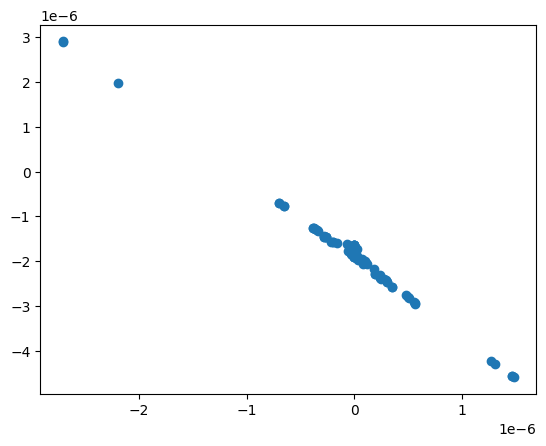

[-8.080421999547232e-09,
 -1.863803354949736e-06,
 6.443378571433877e-07,
 1.1543814084917715e-06]

In [58]:
Pv = L # en coordenadas homogeneas

# Pv en coordenadas cartesianas
x=Pv[:,0]/Pv[:,2]
y=Pv[:,1]/Pv[:,2]

# grafico plt de los puntos
plt.scatter(x,y)
plt.show()
[np.mean(x),np.mean(y),np.std(x),np.std(y)]